---
# GSNR-Based Figure of Merit (FoM) Estimating Span Lengths of Optical Fibers for Equal Transmission Capacity
**Authors:** V. V. Ivanov, J. D. Downie, L. Galdino, Y. Mikhalkova
---


### Import Libraries
Load numerical, plotting, and data analysis packages.

In [1]:
import numpy as np
from scipy.special import lambertw
from matplotlib import pyplot as plt
import scienceplots
import pandas as pd
plt.style.use(['science','ieee', "no-latex"])

### Fiber Parameters
Define attenuation, effective area, dispersion, and other.


|               | Fiber Units | Fiber 1 G.652.D | Fiber 2 G.652.C | Fiber 3 G.654.E | Fiber 4 G.654.E |
| ------------- | ----------- | --------------- | --------------- | --------------- | --------------- |
| Attenuation   | dB/km | 0.183 | 0.158 | 0.166 | 0.150 |
| Effective area | µm^2 | 82 | 83 | 125 | 125 | 
| Dispersion | ps/nm/km | 17 | 18 | 21 | 21 |
| Nonlinear refractive index | x10^-20 m^2/W | 2.3 | 2.1 | 2.2 | 2.1 |


### Initialize Fiber Data
Convert units for attenuation, dispersion, nonlinear index, and effective area.

In [2]:
fiber_titles = np.array(["Fiber 1", "Fiber 2", "Fiber 3", "Fiber 4"])
fiber_cols_ = np.array(["#FFC107", "#1E88E5", "#D81B60", "#000000"])
a=np.array([0.183, 0.158, 0.166, 0.150])                        # fiber attenuation
D= np.array([18, 18, 21, 20.8])[:, np.newaxis]/1e12/1e3/1e-9    # Fiber dispersion (s/m^2) ps -> s /1e12. km -> m *1e3. nm->m * 1e-9
n2 = np.array([2.3, 2.1, 2.2, 2.2])[:, np.newaxis]*1e-20        # Nonlinear refractive index 
Aeff=np.array([80, 83, 125, 125])[:, np.newaxis]*(1e-6)**2      # Effective area um^2->m^2


### System Parameters
Set constants and system-level parameters:
- Planck's constant, wavelength, frequency
- Symbol rate, channel spacing
- EDFA noise figure
- Total WDM bandwidth and number of channels


In [3]:
h = 6.62e-34                        # Planck's constant
lambda_ = 1550e-9                   # channel wavelength, m
nu = 3e8/lambda_                    # channel frequencym Hz
Rs=135e9                            # baud rate, Baud
df = 150e9                          # channels spacing, hz
F=10**(7/10)                        # Linear noise figure
BWDM = 5e12                         # Total transmission bandwidth, Hz 
Nch = BWDM/df                       # number of WDM channels 


### Span Length Range
Define span lengths to test and compute number of spans for total distance.


In [4]:
Ls = np.arange(1,300,0.1)[np.newaxis,:] # Span length, km
Ltot = 2000
Ns=Ltot/Ls

### Effective Attenuation
Include splice and connector losses:

$\alpha^{total}=\alpha^{fiber}+ {{(L_{span}/L_{section}) \cdot A_{splice}+ 2 \cdot A_{connector}} \over {L_{span}}}$

In [5]:
splice_loss = 0.03 # dB
section_length = 10 # km, cable section length between 2 splices 
connector_loss = 0.1 # dB at each end of the span
atten_dbkm_to_1m = np.log(10)/10/1000
added_atten= (1/Ls*((Ls/section_length)*splice_loss+2*connector_loss))*atten_dbkm_to_1m
alpha=added_atten+a[:, np.newaxis]*atten_dbkm_to_1m


### Load ISRS-GN Model Results
Import GSNR data from external CSV file


In [6]:
filepath="./ISRS_GN_GSNR_dB_1550nm.csv"
dataframe = pd.read_csv(filepath)
Ls_ISRS = dataframe['Span length [km]'].to_numpy()
GSNRs_ISRS_GN = dataframe.to_numpy()[:,1::].T


### GSNR Calculation
Define two models:
- **GN Model:** Based on [9] P. Poggiolini et al. “The GN-Model of Fiber Non-Linear Propagation and its Applications,” JLT, vol. 32, no. 4, pp. 694-721 (2014). Eq. 37
- **FoM Model:** Analytical approximation using Eq. (1) from the paper.


In [7]:
def GSNR_GN(n2, Aeff, alpha, F, Ls_, Rs, D, BWDM, Ns): 
    Ls = Ls_*1000
    gamma = 2*np.pi/lambda_*n2/Aeff     # nonlinear coefficient
    beta2 = -D/2/np.pi/3e8*lambda_**2   # beta2 dispersion 

    Leff = (1-np.exp(-alpha*Ls))/alpha
    
    ASE = h*nu*(F*np.exp(alpha*Ls))*Rs
    NLI = 1/Rs**2*(8/27*gamma**2
              *(Leff)**2
               *np.arcsinh(np.pi**2/2*np.abs(beta2)*Leff*Rs**2*Nch**(2*Rs/df))/(np.pi*np.abs(beta2)*Leff))
    Popt = (ASE/(2*NLI))**(1/3)
    return (Popt/((Ns*ASE+Ns*NLI*Popt**3)))

# Eq. for GSNR-based FoM
def GSNR_FoM(n2, Aeff, alpha, F, Ls_, Rs, D, BWDM, Ns): 
    Ls = Ls_*1000
    Q = 1/(Ns*Ls)*lambda_**2/(2*np.pi*3e8)*((h*F)**-2/(2*8/27*np.log(np.pi*BWDM**2)/np.pi))**(1/3)
    FoM = Ls*(alpha*np.abs(D)*(Aeff/n2*np.exp(-alpha*Ls))**2)**(1/3)
    return FoM*Q

In [8]:
models = [None, GSNR_GN, GSNR_FoM]
model_titles = ['ISRS-GN model', 'GN model', 'FoM-based model']
model_linewidths = [3, 3, 3]
model_dashes = ['-', '--', ':']


### GSNR vs Span Length
Compare three models:
- ISRS-GN (reference)
- GN Model
- FoM-based Model (with 1 dB offset for approximations)

Reproduces Fig. 1 of the paper

Text(0.084, 0.5, 'GSNR (dB)\nafter 2000 km')

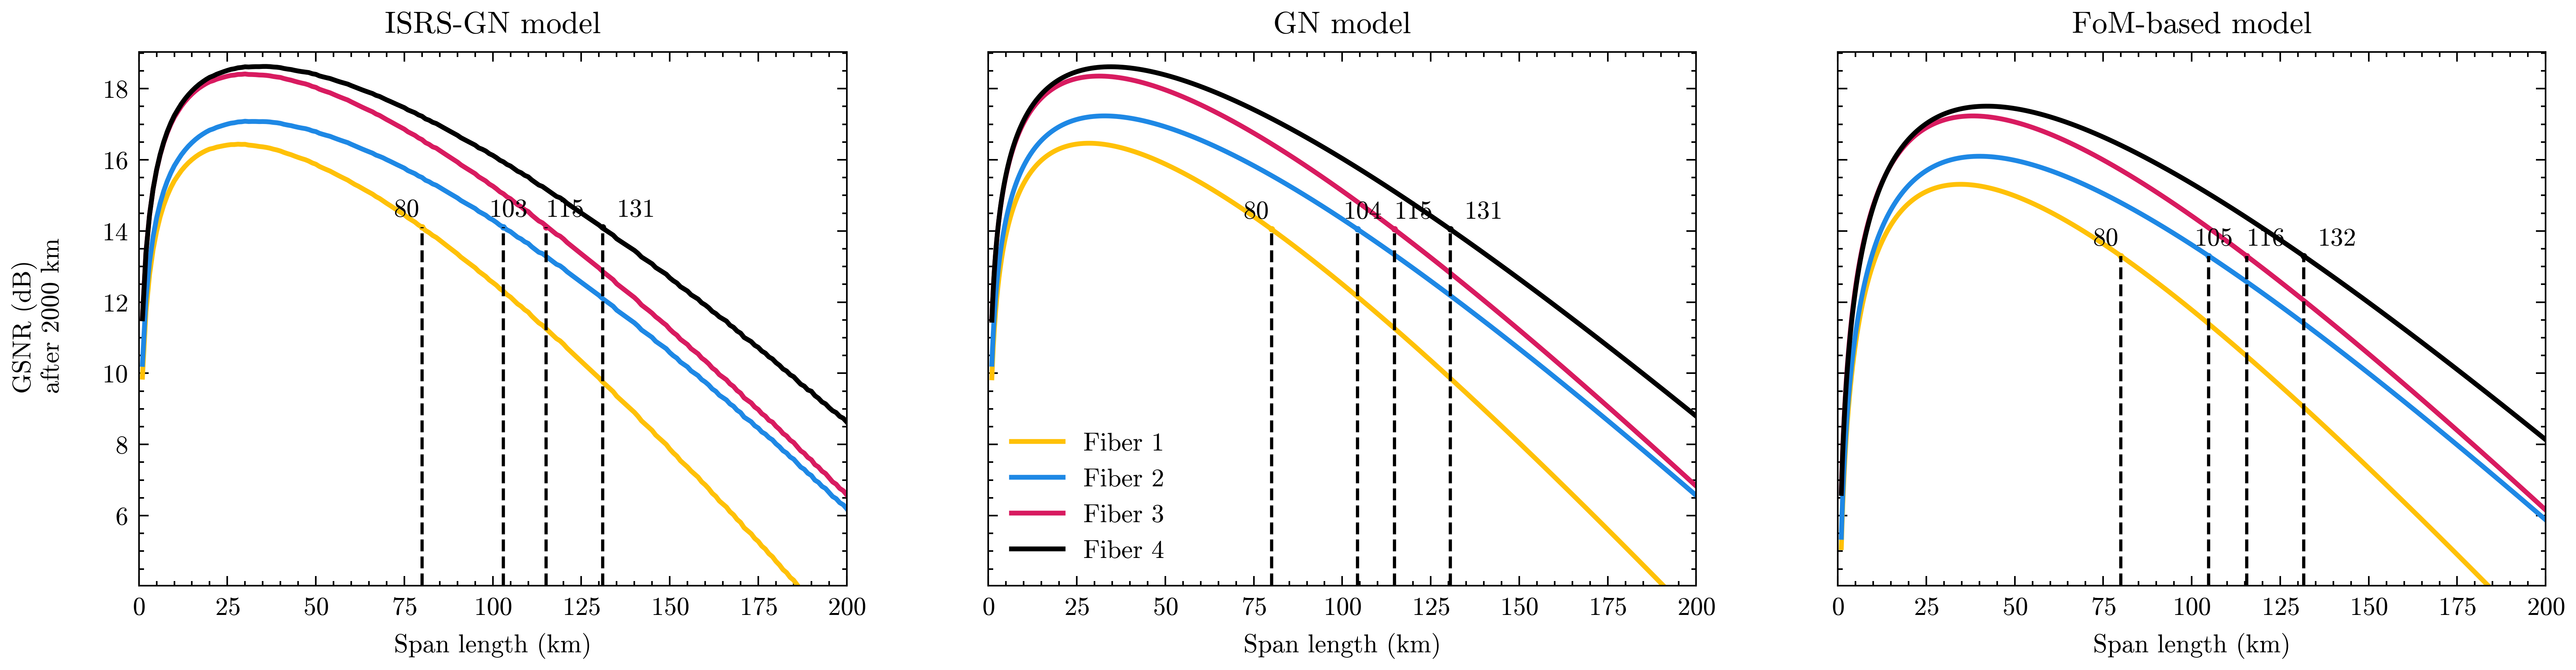

In [9]:
fig, ax = plt.subplots(1,3,figsize=(12.8/5*3*1.75,3), sharey=True,sharex=True,)

for model_id in range(len(model_titles)):
    if model_id == 0:
        Ls__ = Ls_ISRS.astype(int)
        GSNR_fiber = GSNRs_ISRS_GN
    elif model_id == 1:
        Ls__ = Ls[0]
        GSNR_fiber = 10*np.log10(GSNR_GN(n2, Aeff, alpha, F, Ls, Rs, D, BWDM, Ns))
    elif model_id == 2:
        Ls__ = Ls[0]
        GSNR_fiber = 10*np.log10(GSNR_FoM(n2, Aeff, alpha, F, Ls, Rs, D, BWDM, Ns))
    
    length_80 = np.argmin(np.abs(Ls__-80))
    ultra_GSNR_80 = GSNR_fiber[0, length_80]
    length_GSNR_same_as_Ultra = np.argmin(np.abs(ultra_GSNR_80-GSNR_fiber[:,length_80::]), axis=-1)
    
    for fiber_id in np.arange(0,len(fiber_titles)):
        ax[model_id].plot(Ls__, GSNR_fiber[fiber_id], fiber_cols_[fiber_id], label=fiber_titles[fiber_id]+'', linewidth=1.5, linestyle='solid')
        
        ax[model_id].scatter([Ls__[length_80+length_GSNR_same_as_Ultra[fiber_id]]], [ultra_GSNR_80], s=1, c=fiber_cols_[fiber_id])
        ax[model_id].text(Ls__[length_80+length_GSNR_same_as_Ultra[fiber_id]]+(fiber_id-2)*4, ultra_GSNR_80+0.3, 
                   str(int(np.round(Ls__[length_80+length_GSNR_same_as_Ultra[fiber_id]],0))))
        
        ax[model_id].plot([Ls__[length_80+length_GSNR_same_as_Ultra[fiber_id]],Ls__[length_80+length_GSNR_same_as_Ultra[fiber_id]]], [-7.5, ultra_GSNR_80], 'k--')
    
    ax[model_id].set_xlim(0,200)
    ax[model_id].set_ylim(-5+10*np.log10(16000/2000), 10+10*np.log10(16000/2000))
    ax[model_id].set_xlabel('Span length (km)')
    ax[model_id].set_title(model_titles[model_id])

handles, labels = ax[1].get_legend_handles_labels()

ax[1].legend(handles, fiber_titles,  ncol=1, loc='lower left', bbox_to_anchor=(.0, -0.))

fig.text(0.08/5*3*1.75, 0.5, "GSNR (dB)\nafter 2000 km", va='center', rotation='vertical')


### FoM-Based Span Length
Implement Eq. (2) and Eq. (3) from the paper:

$FoM = L_s \sqrt[3]{\alpha |D| ({{Aeff} \over {n_2}} e^{-\alpha L_s})} $

$L_s^{adv} = -{3 \over {2 \alpha_{adv}}}  W_{-1}(-{2 \over 3}{{FoM^{ref}} \over {\sqrt[3]{|D^{adv}| (L_s^{adv} A_{eff}^{adv} / n_2^{adv} / \alpha^{adv})}})})   $


In [10]:
def Ls_FoM(Ls_, a_ref, D_ref,Aeff_ref, n2_ref, 
           a, D, Aeff, n2):
    Ls_ref = Ls_*1000 #km to m
    FoM_ref = Ls_ref*(a_ref*np.abs(D_ref)*(Aeff_ref/n2_ref*np.exp(-a_ref*Ls_ref))**2)**(1/3)
    Ls_adv = -3/2/a*lambertw(-2/3*FoM_ref/(D*(Aeff/n2/a)**2)**(1/3), -1)/1000
    return np.real(Ls_adv)


### Compute Equal-GSNR Span Lengths
For each model:
- ISRS-GN and GN: Use GSNR data to find span lengths with equal GSNR.
- FoM: Compute analytically using Eq. (3).


In [11]:
result_lengths = np.ndarray((len(models), len(fiber_titles)), dtype=object)

for model_id in range(len(models)):
    if model_id == 0:
        Ls__ = Ls_ISRS.astype(int)
        GSNR_fiber = GSNRs_ISRS_GN
    elif model_id == 1:
        Ls__ = Ls[0]
        GSNR_fiber = 10*np.log10(GSNR_GN(n2, Aeff, alpha, F, Ls, Rs, D, BWDM, Ns))
    elif model_id == 2:
        Ls__ = Ls[0]

    for i in np.arange(1,len(fiber_titles)):
        result_lengths[model_id, i] = np.zeros((len(Ls__)))

    if model_id == 0 or model_id == 1:
        for ultra_spanlen_id in range(len(Ls__)):
    
            length_80 = np.argmin(np.abs(Ls__-Ls__[ultra_spanlen_id]))
            ultra_GSNR_80 = GSNR_fiber[0, length_80]
            length_GSNR_same_as_Ultra = np.argmin(np.abs(ultra_GSNR_80-GSNR_fiber[:,ultra_spanlen_id::]), axis=-1)
            
            for i in np.arange(1,len(fiber_titles)):
                result_lengths[model_id, i][ultra_spanlen_id] = Ls__[ultra_spanlen_id+length_GSNR_same_as_Ultra[i]]
    elif model_id == 2:
        Ls_new = Ls_FoM(Ls__, alpha[0], D[0], Aeff[0], n2[0], alpha, D, Aeff, n2)
        for i in np.arange(1,len(fiber_titles)):
            result_lengths[model_id,i] = Ls_new[i]


### Equal-GSNR Span Lengths
Reproduce Fig. 2 from the paper: span lengths for different fibers providing equal GSNR.


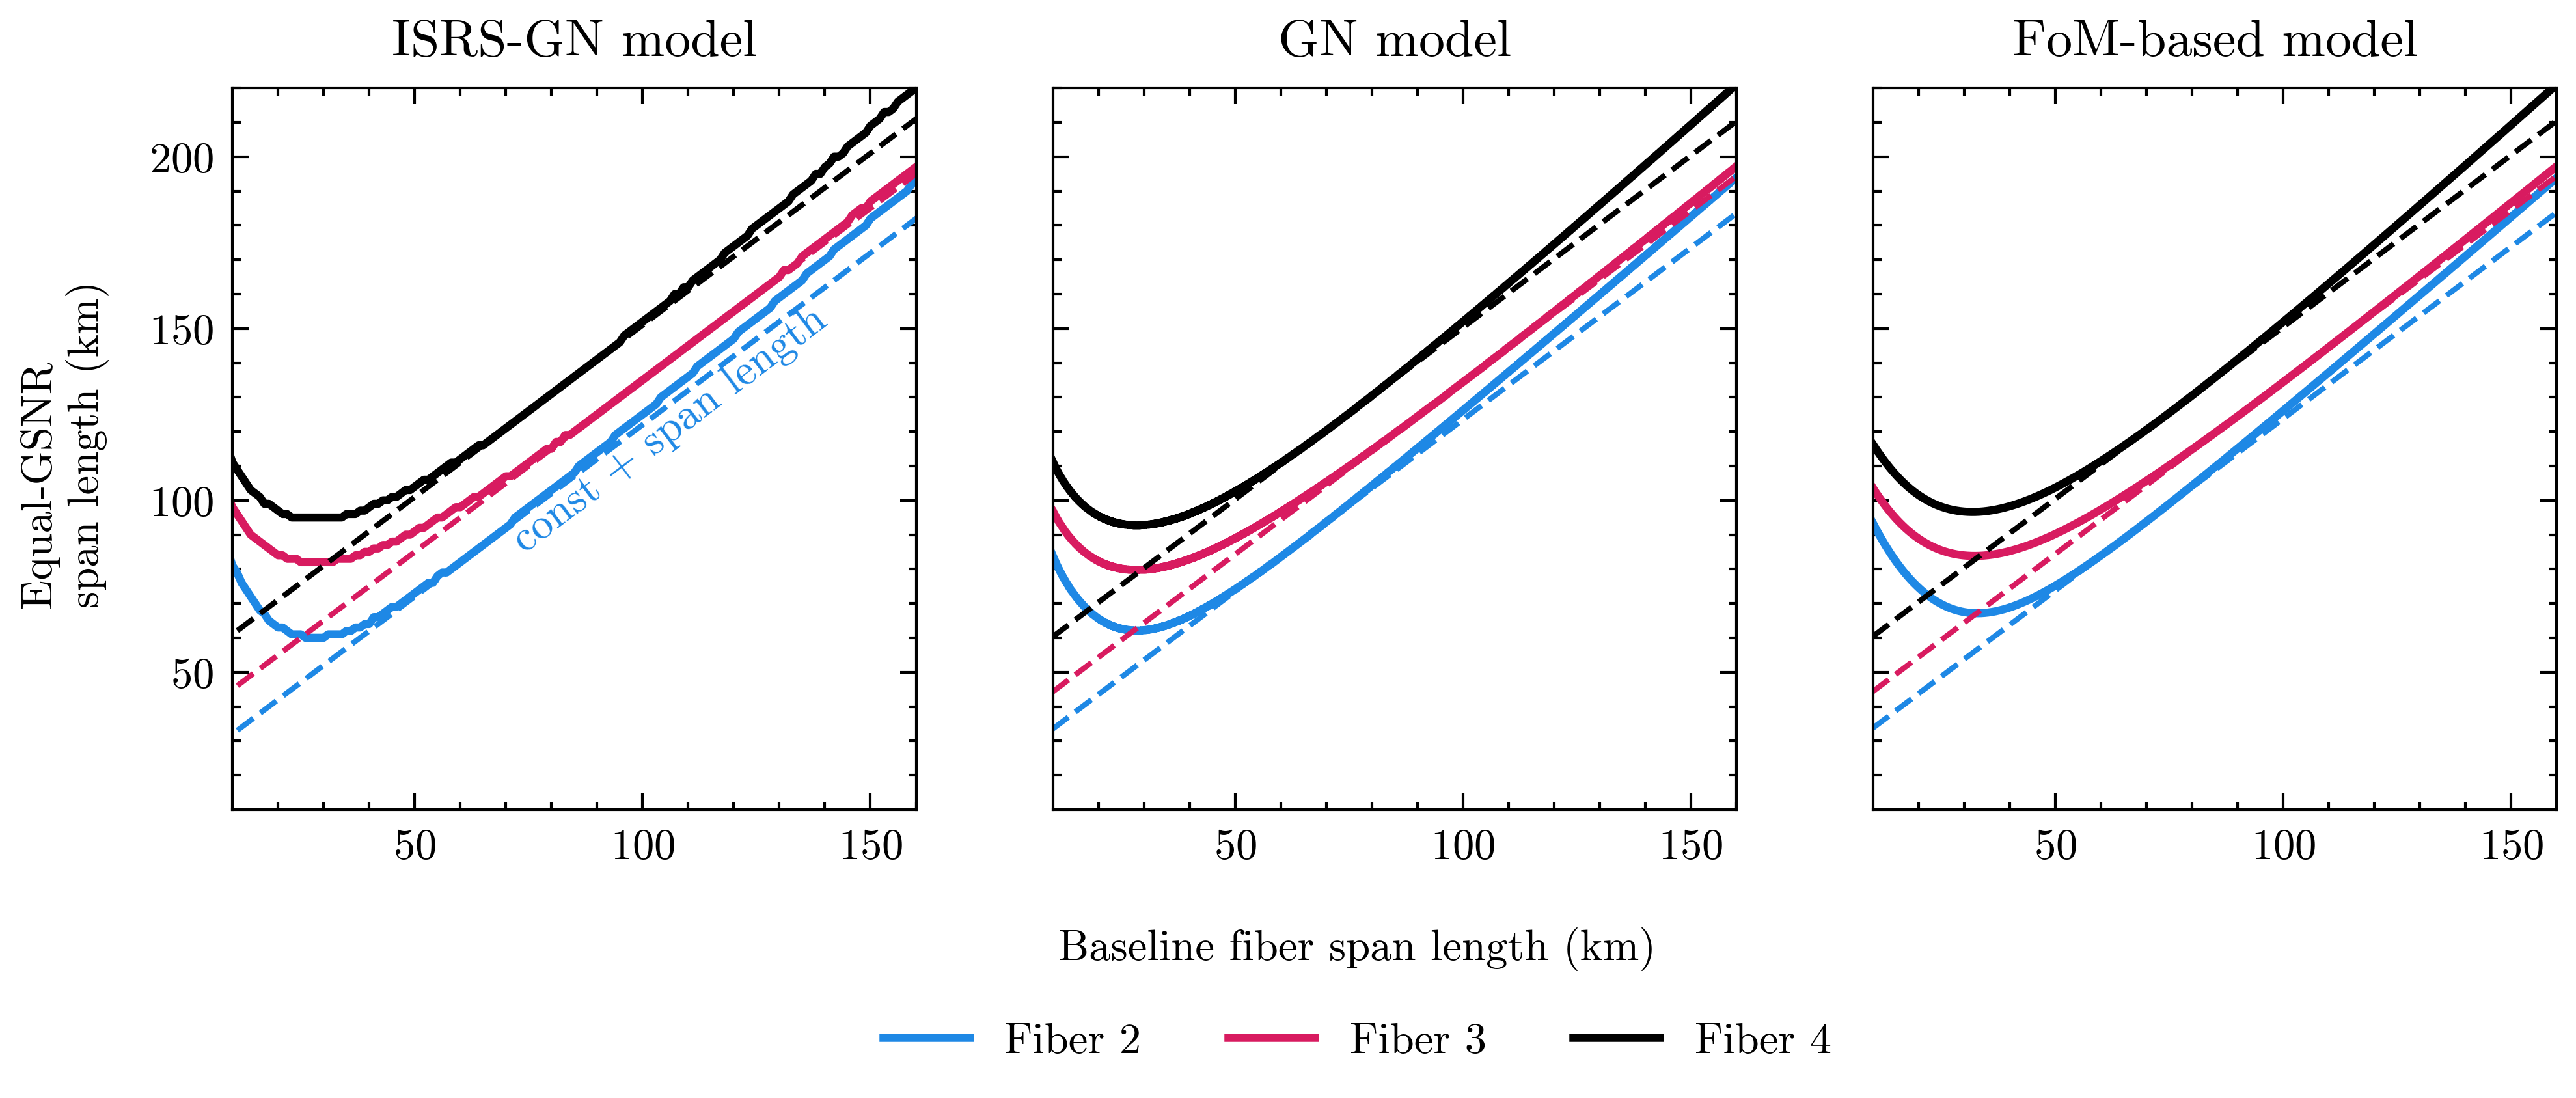

In [12]:
fig, ax = plt.subplots(1,len(models),figsize=(12.8/5*len(models),2.4), sharey=True,sharex=True,)
for model_id in range(len(models)):
    if model_id == 0:
        Ls__ = Ls_ISRS.astype(int)
    elif model_id == 1:
        Ls__ = Ls[0]
    elif model_id == 2:
        Ls__ = Ls[0]

    id_80 = np.argmin(np.abs(Ls__-80))
    id_60 = np.argmin(np.abs(Ls__-60))
    id_130 = np.argmin(np.abs(Ls__-130))
    
    for i in np.arange(1,len(fiber_titles)):
        label=fiber_titles[i]
        
        ax[model_id].plot(Ls__, result_lengths[model_id,i], fiber_cols_[i],label=label, linewidth=1.5, linestyle='solid')#model_titles[model_id]+' '+, linewidth=model_linewidths[model_id], model_dashes[model_id]
        ax[model_id].set_title(model_titles[model_id])

        impr_at_80 = (result_lengths[model_id, i][id_80]-80)
        min_impr=np.min(result_lengths[model_id,i][id_60:id_130]-Ls__[id_60:id_130])
        ax[model_id].plot(Ls__, min_impr+Ls__, c=fiber_cols_[i], linestyle='--')

    ax[model_id].set_xlim(10,160)
    ax[model_id].set_ylim(10,220)
    
    if model_id == 0:
        ax[model_id].text(70,85,'const + span length', rotation=37,c=fiber_cols_[1])
     
handles, labels = ax[model_id].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5,bbox_to_anchor=(0.5,-0.2))
fig.text(0.5, -0.05, 'Baseline fiber span length (km)', ha='center')
fig.text(0.09/5*len(models), 0.5, "Equal-GSNR\nspan length (km)", va='center', rotation='vertical')
fig.savefig("fig5plots0.jpg", dpi=600)


### Span Length Improvement
Reproduce Fig. 3 from the paper: improvement vs baseline fiber.


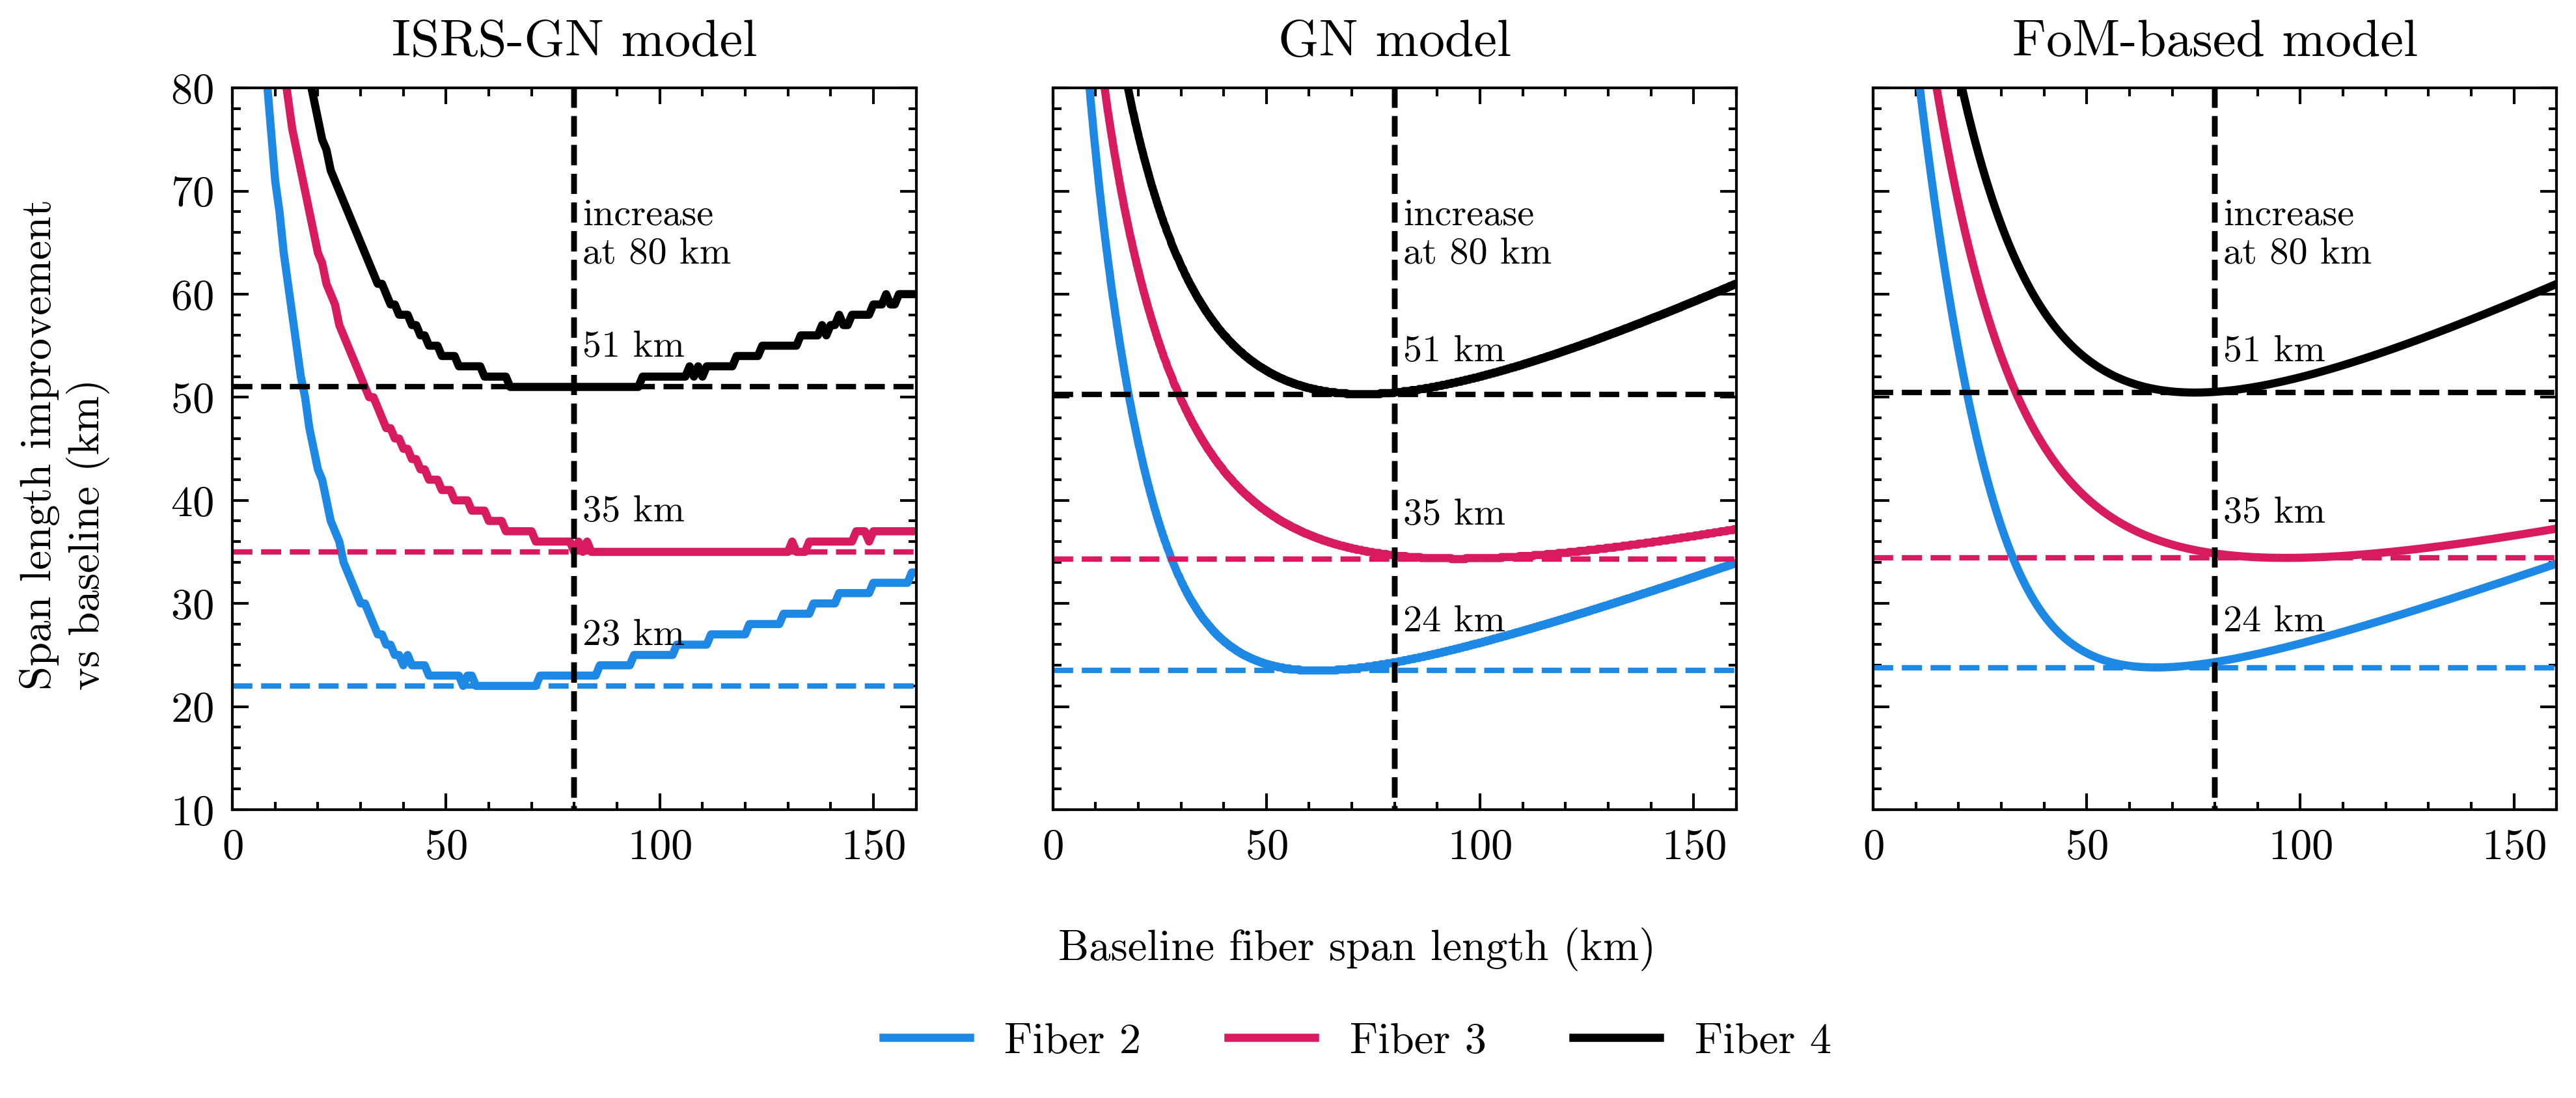

In [13]:
fig, ax = plt.subplots(1,len(models),figsize=(12.8/5*len(models),2.4), sharey=True,sharex=True,)
for model_id in range(len(models)):
    if model_id == 0:
        Ls__ = Ls_ISRS.astype(int)
    elif model_id == 1 or  model_id == 2:
        Ls__ = Ls[0]
    id_80 = np.argmin(np.abs(Ls__-80))
    id_60 = np.argmin(np.abs(Ls__-60))
    id_130 = np.argmin(np.abs(Ls__-130))
    
    for i in np.arange(1,len(fiber_titles)):
        ax[model_id].plot(Ls__, result_lengths[model_id,i]-Ls__, fiber_cols_[i], label=fiber_titles[i], linewidth=1.5, linestyle='solid')#model_titles[model_id]+' '+, linewidth=model_linewidths[model_id], model_dashes[model_id]
        ax[model_id].set_title(model_titles[model_id])

        ax[model_id].plot([80, 80], [0, 100], 'k--')
        
        impr_at_80 = (result_lengths[model_id, i][id_80]-80)

        if i!=0:
            ax[model_id].text(82, impr_at_80+3, str(np.round(impr_at_80, 0).astype(int))+' km', fontsize=7)
        
        min_impr=np.min(result_lengths[model_id,i][id_60:id_130]-Ls__[id_60:id_130])
        max_impr=np.max(result_lengths[model_id,i][id_60:id_130]-Ls__[id_60:id_130])
        ax[model_id].plot([0, 220], [min_impr, min_impr], c=fiber_cols_[i], linestyle='--')
        ax[model_id].set_xlim(0,160)
        ax[model_id].set_ylim(10,80)
        
    ax[model_id].text(82, 63, 'increase\nat 80 km',  fontsize=7)
handles, labels = ax[model_id].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5,-0.2))
fig.text(0.5, -0.05, 'Baseline fiber span length (km)', ha='center')
fig.text(0.09/5*len(models), 0.5, "Span length improvement\nvs baseline (km)", va='center', rotation='vertical')
fig.savefig("fig5plots.jpg", dpi=600)